In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import math
import matplotlib.pyplot as plt

In [2]:
# create seed
torch.manual_seed(42)
np.random.seed(42)


In [3]:
def load_datasets():
    train_set = pd.read_parquet('loaded_data/a_patient_data_processed_cluster.parquet')
    test_set = pd.read_parquet('loaded_data/c_patient_data_processed_cluster.parquet')
    return train_set, test_set

train_df, test_df = load_datasets()

X_train = torch.tensor(train_df.drop(columns=["ICUType", "In-hospital_death"]).values, dtype=torch.float32)
y_train = torch.tensor(train_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_df.drop(columns=["ICUType", "In-hospital_death"]).values, dtype=torch.float32)
y_test = torch.tensor(test_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)

feature_columns = [col for col in train_df.columns if col not in ["RecordID", "In-hospital_death", "ICUType"]]

grouped = train_df.groupby("RecordID")

def pad_to_fixed_length(tensor, length=49):
    current_length = tensor.size(0)
    if current_length < length:
        padding = torch.zeros((length - current_length, tensor.size(1)))
        return torch.cat([tensor, padding], dim=0)
    else:
        return tensor

def process_dataframe(df):
    list_of_patient_tensors = []
    patient_labels = []
    grouped = df.groupby("RecordID")
    for record_id, group in grouped:
        group_tensor = torch.tensor(group[feature_columns].values, dtype=torch.float32)
        group_tensor_fixed = pad_to_fixed_length(group_tensor, length=49)
        list_of_patient_tensors.append(group_tensor_fixed)
        # For the label, we assume that if any timestep indicates death, the patient is labeled as death (1)
        patient_labels.append(group["In-hospital_death"].max())
    sequences = torch.stack(list_of_patient_tensors, dim=0)  
    labels = torch.tensor(patient_labels, dtype=torch.float32).unsqueeze(1)
    return sequences, labels

# Process training and testing data
padded_sequences_train, labels_tensor_train = process_dataframe(train_df)
padded_sequences_test, labels_tensor_test = process_dataframe(test_df)
print(padded_sequences_train.size(), labels_tensor_train.size())

torch.Size([3997, 49, 41]) torch.Size([3997, 1])


In [4]:
def random_sample(X, y, n_samples):
    indices = np.random.choice(len(X), size=n_samples, replace=False)
    return X[indices], y[indices]

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=49):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:,:pe[:, 1::2].shape[1]]
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=41, model_dim=64, num_heads=4, num_layers=2, num_classes=1, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(d_model=model_dim, max_len=49)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(model_dim, num_classes)
    
    def forward(self, x):
        x = self.input_linear(x)          
        x = self.positional_encoding(x)  
        x = x.transpose(0, 1)             
        x = self.transformer_encoder(x)   
        x = x.mean(dim=0)          
        logits = self.classifier(x) 
        return logits




In [13]:
def train_model(model, train_loader, criterion, optimizer, device):
    num_epochs = 50
    epoch_losses = [] 

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        num_batches = len(train_loader)
        
        for batch_data, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()           # Zero the gradients
            logits = model(batch_data)        # Forward pass
            loss = criterion(logits, batch_labels)  # Compute loss
            loss.backward()                   # Backpropagation
            optimizer.step()                  # Update weights
            
            running_loss += loss.item()       # Accumulate batch loss
        
        avg_loss = running_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

    # Plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    return model


In [14]:

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            logits = model(batch_data)
            loss = criterion(logits, batch_labels)
            
            batch_size = batch_data.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Convert logits to probabilities and then binary predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(batch_labels.cpu())
    
    # Compute average loss over all samples
    avg_loss = total_loss / total_samples
    
    # Concatenate all predictions, probabilities, and labels
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Overall accuracy
    overall_accuracy = (all_preds.eq(all_labels)).float().mean().item()
    
    # Accuracy for predicting 1 (sensitivity): among all true positives, how many were predicted as 1
    pos_idx = (all_labels == 1).squeeze()
    if pos_idx.sum() > 0:
        accuracy_pos = (all_preds[pos_idx].eq(all_labels[pos_idx])).float().mean().item()
    else:
        accuracy_pos = float('nan')
    
    # Accuracy for predicting 0 (specificity): among all true negatives, how many were predicted as 0
    neg_idx = (all_labels == 0).squeeze()
    if neg_idx.sum() > 0:
        accuracy_neg = (all_preds[neg_idx].eq(all_labels[neg_idx])).float().mean().item()
    else:
        accuracy_neg = float('nan')
    
    # Compute AUROC using probabilities (make sure to flatten the arrays)
    # Compute AUPRC
    try:
        auroc = roc_auc_score(all_labels.numpy(), all_probs.numpy())
        auprc = average_precision_score(all_labels.numpy(), all_probs.numpy())
    except Exception as e:
        auroc = None
        print("Error computing AUROC:", e)
    
    return avg_loss, overall_accuracy, accuracy_pos, accuracy_neg, auroc, auprc


In [15]:
# Create TensorDatasets and DataLoaders
batch_size = 32



test_dataset = TensorDataset(padded_sequences_test, labels_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/50] - Average Loss: 1.1266


Epoch [2/50] - Average Loss: 1.5540


Epoch [3/50] - Average Loss: 1.3985


Epoch [4/50] - Average Loss: 1.2150


Epoch [5/50] - Average Loss: 1.6946


Epoch [6/50] - Average Loss: 1.1308


Epoch [7/50] - Average Loss: 1.0813


Epoch [8/50] - Average Loss: 1.0131


Epoch [9/50] - Average Loss: 1.3768


Epoch [10/50] - Average Loss: 0.9605


Epoch [11/50] - Average Loss: 1.0809


Epoch [12/50] - Average Loss: 0.9087


Epoch [13/50] - Average Loss: 0.8683


Epoch [14/50] - Average Loss: 0.8004


Epoch [15/50] - Average Loss: 0.7403


Epoch [16/50] - Average Loss: 1.1492


Epoch [17/50] - Average Loss: 0.8663


Epoch [18/50] - Average Loss: 0.8342


Epoch [19/50] - Average Loss: 0.5851


Epoch [20/50] - Average Loss: 0.5962


Epoch [21/50] - Average Loss: 0.6470


Epoch [22/50] - Average Loss: 0.5812


Epoch [23/50] - Average Loss: 0.4346


Epoch [24/50] - Average Loss: 0.3693


Epoch [25/50] - Average Loss: 0.5810


Epoch [26/50] - Average Loss: 0.7864


Epoch [27/50] - Average Loss: 0.3717


Epoch [28/50] - Average Loss: 0.7810


Epoch [29/50] - Average Loss: 0.4059


Epoch [30/50] - Average Loss: 0.3516


Epoch [31/50] - Average Loss: 0.3529


Epoch [32/50] - Average Loss: 0.3462


Epoch [33/50] - Average Loss: 0.2720


Epoch [34/50] - Average Loss: 0.2395


Epoch [35/50] - Average Loss: 0.2208


Epoch [36/50] - Average Loss: 0.3271


Epoch [37/50] - Average Loss: 0.2225


Epoch [38/50] - Average Loss: 0.3830


Epoch [39/50] - Average Loss: 0.5469


Epoch [40/50] - Average Loss: 0.3209


Epoch [41/50] - Average Loss: 0.4132


Epoch [42/50] - Average Loss: 0.2454


Epoch [43/50] - Average Loss: 0.4753


Epoch [44/50] - Average Loss: 0.2373


Epoch [45/50] - Average Loss: 0.2075


Epoch [46/50] - Average Loss: 0.2863


Epoch [47/50] - Average Loss: 0.2144


Epoch [48/50] - Average Loss: 0.1289


Epoch [49/50] - Average Loss: 0.2102


Epoch [50/50] - Average Loss: 0.1203


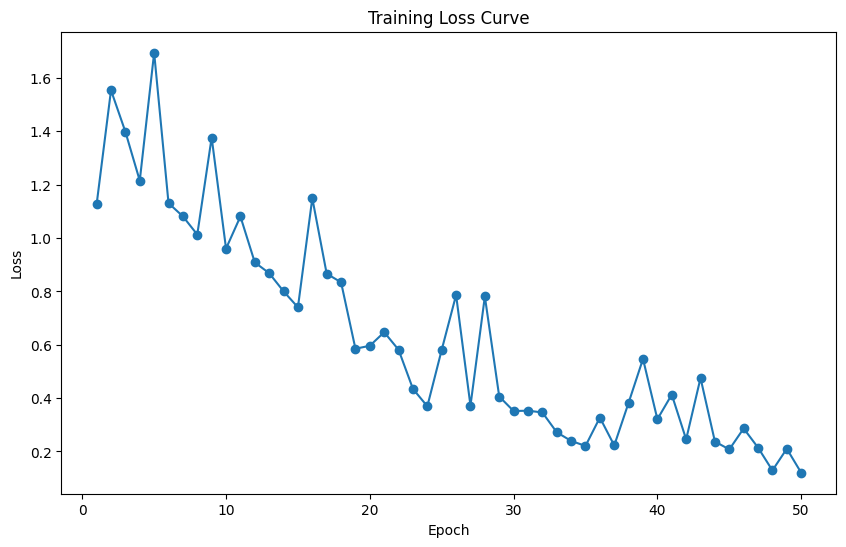

Test Loss: 4.4964
Overall Accuracy: 78.51%
Accuracy for predicting 1 (Sensitivity): 19.15%
Accuracy for predicting 0 (Specificity): 88.69%
AUROC: 0.5700
AUPRC: 0.1965


In [ ]:
num_samples = 100


X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)
weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/50] - Average Loss: 1.4877


Epoch [2/50] - Average Loss: 1.3608


Epoch [3/50] - Average Loss: 1.2912


Epoch [4/50] - Average Loss: 1.1726


Epoch [5/50] - Average Loss: 1.1699


Epoch [6/50] - Average Loss: 1.0596


Epoch [7/50] - Average Loss: 1.0123


Epoch [8/50] - Average Loss: 0.9385


Epoch [9/50] - Average Loss: 0.8590


Epoch [10/50] - Average Loss: 0.8141


Epoch [11/50] - Average Loss: 0.8635


Epoch [12/50] - Average Loss: 0.7731


Epoch [13/50] - Average Loss: 0.6992


Epoch [14/50] - Average Loss: 0.7276


Epoch [15/50] - Average Loss: 0.6800


Epoch [16/50] - Average Loss: 0.5727


Epoch [17/50] - Average Loss: 0.5061


Epoch [18/50] - Average Loss: 0.4587


Epoch [19/50] - Average Loss: 0.4071


Epoch [20/50] - Average Loss: 0.3769


Epoch [21/50] - Average Loss: 0.3524


Epoch [22/50] - Average Loss: 0.3049


Epoch [23/50] - Average Loss: 0.4114


Epoch [24/50] - Average Loss: 0.3187


Epoch [25/50] - Average Loss: 0.2442


Epoch [26/50] - Average Loss: 0.2156


Epoch [27/50] - Average Loss: 0.2502


Epoch [28/50] - Average Loss: 0.2304


Epoch [29/50] - Average Loss: 0.1686


Epoch [30/50] - Average Loss: 0.1325


Epoch [31/50] - Average Loss: 0.1273


Epoch [32/50] - Average Loss: 0.1038


Epoch [33/50] - Average Loss: 0.0804


Epoch [34/50] - Average Loss: 0.0740


Epoch [35/50] - Average Loss: 0.0501


Epoch [36/50] - Average Loss: 0.0451


Epoch [37/50] - Average Loss: 0.0382


Epoch [38/50] - Average Loss: 0.0323


Epoch [39/50] - Average Loss: 0.0244


Epoch [40/50] - Average Loss: 0.0260


Epoch [41/50] - Average Loss: 0.0246


Epoch [42/50] - Average Loss: 0.0181


Epoch [43/50] - Average Loss: 0.0150


Epoch [44/50] - Average Loss: 0.0143


Epoch [45/50] - Average Loss: 0.0127


Epoch [46/50] - Average Loss: 0.0114


Epoch [47/50] - Average Loss: 0.0095


Epoch [48/50] - Average Loss: 0.0093


Epoch [49/50] - Average Loss: 0.0085


Epoch [50/50] - Average Loss: 0.0086


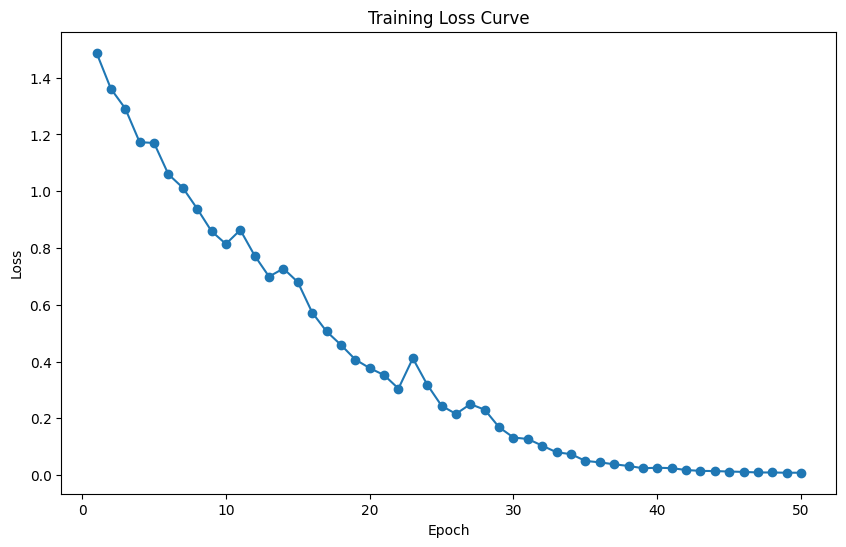

Test Loss: 5.6305
Overall Accuracy: 80.72%
Accuracy for predicting 1 (Sensitivity): 28.89%
Accuracy for predicting 0 (Specificity): 89.60%
AUROC: 0.6855
AUPRC: 0.2817


In [ ]:
num_samples = 500


X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/50] - Average Loss: 1.4608


Epoch [2/50] - Average Loss: 1.3807


Epoch [3/50] - Average Loss: 1.2091


Epoch [4/50] - Average Loss: 1.2858


Epoch [5/50] - Average Loss: 1.1475


Epoch [6/50] - Average Loss: 1.1737


Epoch [7/50] - Average Loss: 1.0492


Epoch [8/50] - Average Loss: 1.0532


Epoch [9/50] - Average Loss: 0.9791


Epoch [10/50] - Average Loss: 0.9776


Epoch [11/50] - Average Loss: 0.9366


Epoch [12/50] - Average Loss: 0.9617


Epoch [13/50] - Average Loss: 0.9080


Epoch [14/50] - Average Loss: 0.8406


Epoch [15/50] - Average Loss: 0.8567


Epoch [16/50] - Average Loss: 0.7803


Epoch [17/50] - Average Loss: 0.7639


Epoch [18/50] - Average Loss: 0.8634


Epoch [19/50] - Average Loss: 0.7353


Epoch [20/50] - Average Loss: 0.7031


Epoch [21/50] - Average Loss: 0.7425


Epoch [22/50] - Average Loss: 0.6038


Epoch [23/50] - Average Loss: 0.5646


Epoch [24/50] - Average Loss: 0.4870


Epoch [25/50] - Average Loss: 0.4785


Epoch [26/50] - Average Loss: 0.4267


Epoch [27/50] - Average Loss: 0.4222


Epoch [28/50] - Average Loss: 0.3409


Epoch [29/50] - Average Loss: 0.2985


Epoch [30/50] - Average Loss: 0.3031


Epoch [31/50] - Average Loss: 0.3602


Epoch [32/50] - Average Loss: 0.3366


Epoch [33/50] - Average Loss: 0.2535


Epoch [34/50] - Average Loss: 0.2608


Epoch [35/50] - Average Loss: 0.2306


Epoch [36/50] - Average Loss: 0.1450


Epoch [37/50] - Average Loss: 0.1442


Epoch [38/50] - Average Loss: 0.3275


Epoch [39/50] - Average Loss: 0.1915


Epoch [40/50] - Average Loss: 0.1290


Epoch [41/50] - Average Loss: 0.0770


Epoch [42/50] - Average Loss: 0.0650


Epoch [43/50] - Average Loss: 0.0461


Epoch [44/50] - Average Loss: 0.0361


Epoch [45/50] - Average Loss: 0.0276


Epoch [46/50] - Average Loss: 0.0255


Epoch [47/50] - Average Loss: 0.0214


Epoch [48/50] - Average Loss: 0.0183


Epoch [49/50] - Average Loss: 0.0146


Epoch [50/50] - Average Loss: 0.0114


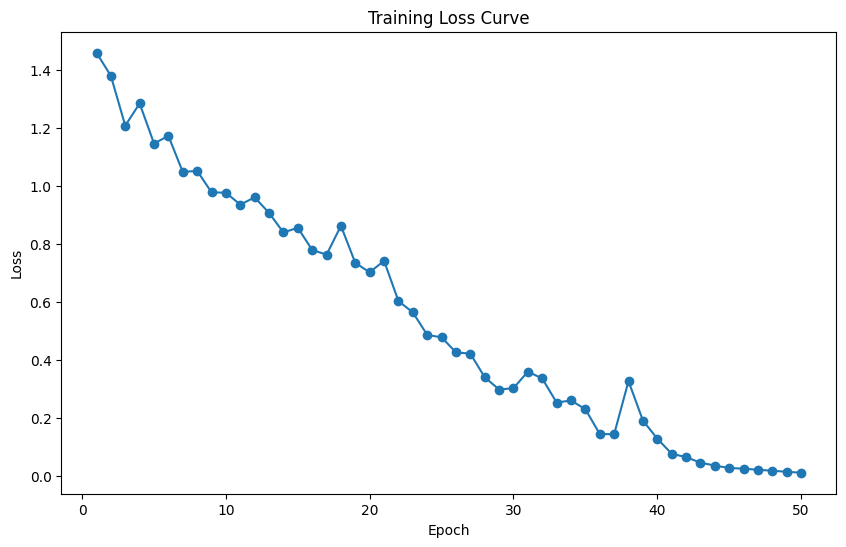

Test Loss: 6.2982
Overall Accuracy: 83.07%
Accuracy for predicting 1 (Sensitivity): 34.36%
Accuracy for predicting 0 (Specificity): 91.42%
AUROC: 0.7508
AUPRC: 0.3545


In [ ]:
num_samples = 1000

X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/50] - Average Loss: 1.3071


Epoch [2/50] - Average Loss: 1.1543


Epoch [3/50] - Average Loss: 1.1010


Epoch [4/50] - Average Loss: 1.0515


Epoch [5/50] - Average Loss: 1.0191


Epoch [6/50] - Average Loss: 0.9868


Epoch [7/50] - Average Loss: 0.9558


Epoch [8/50] - Average Loss: 0.9328


Epoch [9/50] - Average Loss: 0.9243


Epoch [10/50] - Average Loss: 0.8960


Epoch [11/50] - Average Loss: 0.8756


Epoch [12/50] - Average Loss: 0.8550


Epoch [13/50] - Average Loss: 0.8655


Epoch [14/50] - Average Loss: 0.8463


Epoch [15/50] - Average Loss: 0.7867


Epoch [16/50] - Average Loss: 0.7698


Epoch [17/50] - Average Loss: 0.7277


Epoch [18/50] - Average Loss: 0.7111


Epoch [19/50] - Average Loss: 0.7381


Epoch [20/50] - Average Loss: 0.6680


Epoch [21/50] - Average Loss: 0.6526


Epoch [22/50] - Average Loss: 0.6174


Epoch [23/50] - Average Loss: 0.5982


Epoch [24/50] - Average Loss: 0.5696


Epoch [25/50] - Average Loss: 0.5409


Epoch [26/50] - Average Loss: 0.5367


Epoch [27/50] - Average Loss: 0.4555


Epoch [28/50] - Average Loss: 0.4615


Epoch [29/50] - Average Loss: 0.4332


Epoch [30/50] - Average Loss: 0.3828


Epoch [31/50] - Average Loss: 0.3582


Epoch [32/50] - Average Loss: 0.3662


Epoch [33/50] - Average Loss: 0.3630


Epoch [34/50] - Average Loss: 0.2810


Epoch [35/50] - Average Loss: 0.2952


Epoch [36/50] - Average Loss: 0.2394


Epoch [37/50] - Average Loss: 0.2349


Epoch [38/50] - Average Loss: 0.2292


Epoch [39/50] - Average Loss: 0.2306


Epoch [40/50] - Average Loss: 0.2087


Epoch [41/50] - Average Loss: 0.2660


Epoch [42/50] - Average Loss: 0.1591


Epoch [43/50] - Average Loss: 0.1205


Epoch [44/50] - Average Loss: 0.0937


Epoch [45/50] - Average Loss: 0.1570


Epoch [46/50] - Average Loss: 0.1320


Epoch [47/50] - Average Loss: 0.1850


Epoch [48/50] - Average Loss: 0.1629


Epoch [49/50] - Average Loss: 0.1743


Epoch [50/50] - Average Loss: 0.2322


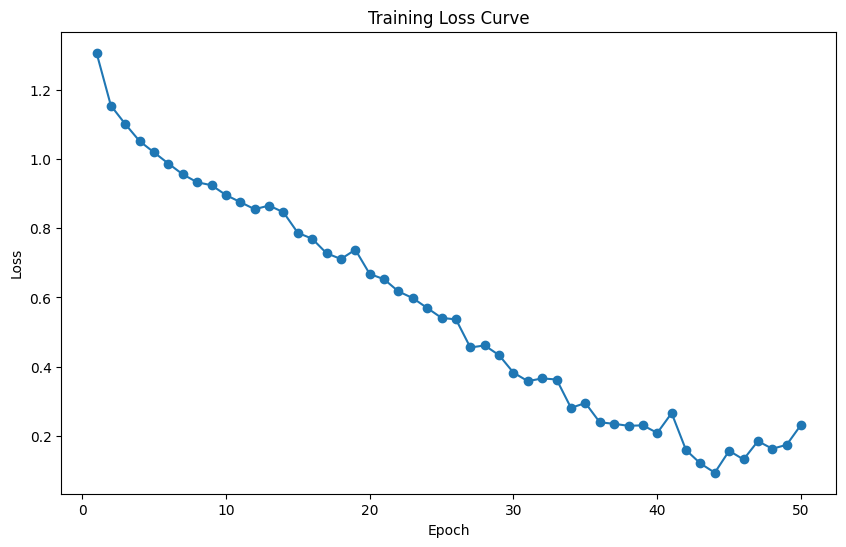

Test Loss: 3.5504
Overall Accuracy: 77.24%
Accuracy for predicting 1 (Sensitivity): 57.78%
Accuracy for predicting 0 (Specificity): 80.57%
AUROC: 0.7814
AUPRC: 0.3814


In [ ]:
# All of the data

train_dataset = TensorDataset(padded_sequences_train, labels_tensor_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")